In [1]:
import torch, os
import numpy as np
from PIL import Image
from tqdm import tqdm

import math
import random
import functools
import operator
from collections import abc

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

import matplotlib.pyplot as plt
import time

In [2]:
class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, bias=True, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        if bias:
            self.bias = nn.Parameter(torch.zeros(channel))

        else:
            self.bias = None

        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)

In [3]:
def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if bias is not None:
        rest_dim = [1] * (input.ndim - bias.ndim - 1)
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=0.2
            )
            * scale
        )

    else:
        return F.leaky_relu(input, negative_slope=0.2) * scale

In [4]:
def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    if not isinstance(up, abc.Iterable):
        up = (up, up)

    if not isinstance(down, abc.Iterable):
        down = (down, down)

    if len(pad) == 2:
        pad = (pad[0], pad[1], pad[0], pad[1])

    out = upfirdn2d_native(input, kernel, *up, *down, *pad)

    return out

In [5]:
def upfirdn2d_native(
    input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1
):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(
        out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)]
    )
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape(
        [-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1]
    )
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h + down_y) // down_y
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w + down_x) // down_x

    return out.view(-1, channel, out_h, out_w)

In [6]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k

In [7]:
class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out

In [8]:
class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out

In [9]:
class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer("kernel", kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out

In [10]:
class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
            f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
        )

In [11]:
class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
        )

In [12]:
class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()

        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)

        return out * math.sqrt(2)

In [13]:
class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, "
            f"upsample={self.upsample}, downsample={self.downsample})"
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out

In [14]:
class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise

In [15]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out

In [16]:
class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out

In [17]:
class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out

In [18]:
class Generator(nn.Module):
    def __init__(
        self,
        size,
        style_dim,
        n_mlp,
        channel_multiplier=2,
        blur_kernel=[1, 3, 3, 1],
        lr_mlp=0.01,
    ):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation="fused_lrelu"
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f"noise_{layer_idx}", torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
        self,
        styles,
        return_latents=False,
        inject_index=None,
        truncation=1,
        truncation_latent=None,
        input_is_latent=False,
        noise=None,
        randomize_noise=True,
    ):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f"noise_{i}") for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

            
        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])
        features = [out]

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)
            features.append(out)
            
            out = conv2(out, latent[:, i + 1], noise=noise2)
            features.append(out)
            
            skip = to_rgb(out, latent[:, i + 2], skip)

            i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, features

In [19]:
class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        bias=True,
        activate=True,
    ):
        layers = []

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            layers.append(Blur(blur_kernel, pad=(pad0, pad1)))

            stride = 2
            self.padding = 0

        else:
            stride = 1
            self.padding = kernel_size // 2

        layers.append(
            EqualConv2d(
                in_channel,
                out_channel,
                kernel_size,
                padding=self.padding,
                stride=stride,
                bias=bias and not activate,
            )
        )

        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channel))

            else:
                layers.append(ScaledLeakyReLU(0.2))

        super().__init__(*layers)

In [20]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        self.conv1 = ConvLayer(in_channel, in_channel, 3)
        self.conv2 = ConvLayer(in_channel, out_channel, 3, downsample=True)

        self.skip = ConvLayer(
            in_channel, out_channel, 1, downsample=True, activate=False, bias=False
        )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        skip = self.skip(input)
        out = (out + skip) / math.sqrt(2)

        return out

In [21]:
class Discriminator(nn.Module):
    def __init__(self, size, channel_multiplier=2, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        convs = [ConvLayer(3, channels[size], 1)]

        log_size = int(math.log(size, 2))

        in_channel = channels[size]

        for i in range(log_size, 2, -1):
            out_channel = channels[2 ** (i - 1)]

            convs.append(ResBlock(in_channel, out_channel, blur_kernel))

            in_channel = out_channel

        self.convs = nn.Sequential(*convs)

        self.stddev_group = 4
        self.stddev_feat = 1

        self.final_conv = ConvLayer(in_channel + 1, channels[4], 3)
        self.final_linear = nn.Sequential(
            EqualLinear(channels[4] * 4 * 4, channels[4], activation="fused_lrelu"),
            EqualLinear(channels[4], 1),
        )

    def forward(self, input):
        out = self.convs(input)

        batch, channel, height, width = out.shape
        group = min(batch, self.stddev_group)
        stddev = out.view(
            group, -1, self.stddev_feat, channel // self.stddev_feat, height, width
        )
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, height, width)
        out = torch.cat([out, stddev], 1)

        out = self.final_conv(out)

        out = out.view(batch, -1)
        out = self.final_linear(out)

        return out


In [22]:
def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    %matplotlib inline
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def horizontal_concat(imgs):
    return torch.cat([img.unsqueeze(0) for img in imgs], 3) 

@torch.no_grad()
def concat_features(features):
    h = max([f.shape[-2] for f in features])
    w = max([f.shape[-1] for f in features])
    return torch.cat([torch.nn.functional.interpolate(f, (h,w), mode='nearest') for f in features], dim=1)

In [23]:
device = 'mps'
image_size = 256
n_samples = 10

generator_path = '/Users/amir/Desktop/repurpose-gan/550000.pt'
latent_dim = 512
truncation = 0.6

imshow_size = 5
output_dir = '/Users/amir/Desktop/AI-final'

In [33]:
from torchvision.utils import save_image

image_path = os.path.join(output_dir, 'images')
features_path = os.path.join(output_dir, 'features')

if not os.path.exists(image_path) or not os.path.exists(features_path):
    os.mkdir(image_path)
    os.mkdir(features_path)

generator = Generator(image_size, latent_dim, 8)
generator_ckpt = torch.load(generator_path, map_location='cpu')
generator.load_state_dict(generator_ckpt["g_ema"], strict=False)
generator.eval().to(device)
print(f'Successfully Loaded Pretrained-Network!\n')


trunc_mean = generator.mean_latent(4096).detach().clone()

In [34]:
with torch.no_grad():
    for i in tqdm(range(n_samples)):
        latent = generator.get_latent(torch.randn(1, latent_dim, device=device))
        imgs_gen, features = generator([latent],
                                       truncation=truncation,
                                       truncation_latent=trunc_mean,
                                       input_is_latent=True,
                                       randomize_noise=True)
        

        image_filename = os.path.join(image_path, f'{i}.png')
        features_filename = os.path.join(features_path, f'{i}')
        
        if not os.path.exists(features_filename):
            os.mkdir(features_filename)
        
        save_image(imgs_gen[0], image_filename)
        
        for idx in range(len(features)):
            torch.save(features[idx], os.path.join(features_filename, f'{idx}.pt'))

        torch.cuda.empty_cache()

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.28it/s]


In [24]:
def get_annots(dir, id=None):
    import json

    id = [str(i) for i in id]
    annots = os.listdir(dir)
    files = [file for file in annots if file.endswith(('.png'))]

    if id:
        files = [file for file in files if file.split('.png')[0] in id]
    
    f = open(os.path.join(dir, 'label_classes.json'))
    data = json.load(f)
    lbl_encodings = [data[i]['png_index'] for i in range(len(data))]

    decoded_labels = []
    
    for annot in files:
        lbl = np.array(Image.open(os.path.join(dir, annot)))
        label = np.zeros(lbl.shape[:-1], dtype=int)
        for i in range(lbl.shape[0]):
            for j in range(lbl.shape[1]):
                encoding = lbl[i, j, :]
                try:
                    lbl_idx = lbl_encodings.index(list(encoding))
                    label[i][j] = (lbl_idx + 1)
                except ValueError:
                    label[i][j] = 0
        decoded_labels.append(label)

    decoded_labels = np.stack(decoded_labels, axis=0)
    decoded_labels = torch.from_numpy(decoded_labels)

    return decoded_labels, lbl_encodings
        

In [25]:
def get_images(dir, id=None):
    id = [str(i) for i in id]
    images = os.listdir(dir)
    files = [file for file in images if file.endswith(('.png'))]

    if id:
        files = [file for file in files if file.split('.png')[0] in id]

    image_list = []

    for img in files:
        image = np.array(Image.open(os.path.join(dir, img)))
        image_list.append(image)

    image_list = np.stack(image_list, axis=0)
    image_list = torch.from_numpy(image_list).permute(0, 3, 1, 2)

    return image_list

In [26]:
def get_features(dir, id=None):
    id = [str(i) for i in id]
    feats = os.listdir(dir)
    files = [file for file in feats if file.endswith(('.pt'))]

    if id:
        files = [file for file in files if file.split('.pt')[0] in id]


    feature_list = []
    
    for f in files:
        feature = torch.load(os.path.join(dir, f))
        feature_list.append(feature)

    feature_list = np.stack(feature_list, axis=0)
    feature_list = torch.from_numpy(feature_list)

    return feature_list

In [27]:
few_shot_samples = [7, 16, 17]
test_samples = [8, 13] #[8, 9, 10, 13, 14]

In [34]:
images = get_images(dir=image_path, id=few_shot_samples)
labels, lbl_encodings = get_annots(dir=os.path.join(output_dir, 'annotations'), id=few_shot_samples)
features = get_features(dir=features_path, id=few_shot_samples)

In [35]:
test_images = get_images(dir=image_path, id=test_samples)
test_labels, test_lbl_encodings = get_annots(dir=os.path.join(output_dir, 'annotations'), id=test_samples)
test_features = get_features(dir=features_path, id=test_samples)

In [28]:
class FewShotCNN(nn.Module):
    def __init__(self, in_ch, n_class):
        super().__init__()
        
        dilations = [1, 2, 1, 2, 1]
        channels = [128, 64, 64, 32]
        
        channels = [in_ch] + channels + [n_class]
        
        layers = []
        for d, c_in, c_out in zip(dilations, channels[:-1], channels[1:]):
            layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.layers = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        return self.layers(x)

In [29]:
def compute_iou(predictions, targets, num_classes):
    intersection = torch.zeros(num_classes)
    union = torch.zeros(num_classes)
    
    # Iterate over each class
    for class_idx in range(num_classes):
        pred_mask = (predictions == class_idx).float()
        target_mask = (targets == class_idx).float()

        intersection[class_idx] = torch.sum(pred_mask * target_mask)
        union[class_idx] = torch.sum(pred_mask) + torch.sum(target_mask) - intersection[class_idx]

    iou = intersection / union

    average_iou = torch.mean(iou)

    return average_iou.item(), iou.numpy()

In [192]:
net = FewShotCNN(features.shape[1], 8)
loss_tracker = []
iou_tracker = []

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

net.train().to(device)
start_time = time.time()
for epoch in range(1, 100+1):
    sample_order = list(range(len(few_shot_samples)))
    random.shuffle(sample_order)
    total_loss = 0
    for idx in sample_order:
        
        sample = features[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)
        out = net(sample)
        
        loss = F.cross_entropy(out, label, reduction='mean')
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_tracker.append(total_loss / len(sample_order))

    test_features = test_features.to(device)
    generator.eval().to(device)
    net.eval().to(device)
    with torch.no_grad():
        torch.cuda.empty_cache()
        out = net(test_features)
        predictions = out.data.max(1)[1].cpu().numpy()
    
    average_iou, class_iou = compute_iou(out.data.max(1)[1].cpu(), test_labels.flip(0), num_classes=8)
    iou_tracker.append(average_iou)

    if epoch % 10 == 0:
        print(f'{epoch:5}-th epoch | loss: {loss.item():6.4f} | Avg IoU: %{average_iou*100} | Class-specific IoU: {class_iou}')

    scheduler.step()
print('Done!')

   10-th epoch | loss: 0.1776 | Avg IoU: %71.52095437049866 | Class-specific IoU: [0.8745838  0.77863675 0.7557574  0.7196532  0.536385   0.7960488
 0.76389486 0.4967167 ]
   20-th epoch | loss: 0.0671 | Avg IoU: %72.97070026397705 | Class-specific IoU: [0.8692048  0.8031895  0.7618206  0.6183816  0.6069422  0.82351154
 0.7975925  0.5570131 ]
   30-th epoch | loss: 0.0969 | Avg IoU: %73.32777976989746 | Class-specific IoU: [0.8759885  0.8100686  0.7591893  0.5910768  0.63524055 0.82371986
 0.78682    0.5841191 ]
   40-th epoch | loss: 0.0765 | Avg IoU: %73.58546257019043 | Class-specific IoU: [0.8605023  0.7864112  0.7616213  0.6159974  0.685442   0.7893117
 0.77609277 0.61145884]
   50-th epoch | loss: 0.0705 | Avg IoU: %71.70851826667786 | Class-specific IoU: [0.8704214  0.8022139  0.7542523  0.6126337  0.5037702  0.814211
 0.77417904 0.605     ]
   60-th epoch | loss: 0.0388 | Avg IoU: %72.49721884727478 | Class-specific IoU: [0.86521924 0.8035565  0.754862   0.6127957  0.6007463  0

In [193]:
class_mapping = {
    0: 'Background',
    1: 'Skin',
    2: 'Hair',
    3: 'Eye',
    4: 'Eyebrow',
    5: 'Nose',
    6: 'Mouth',
    7: 'Ear'
}

In [197]:
print(f"Mean IoU: %{round(average_iou*100,2)}\n")
for idx, prob in enumerate(class_iou):
    print(f'{class_mapping[idx]}: %{round(prob*100, 2)}')

Mean IoU: %72.88

Background: %86.3
Skin: %80.39
Hair: %75.1
Eye: %61.01
Eyebrow: %62.04
Nose: %82.34
Mouth: %79.04
Ear: %56.78


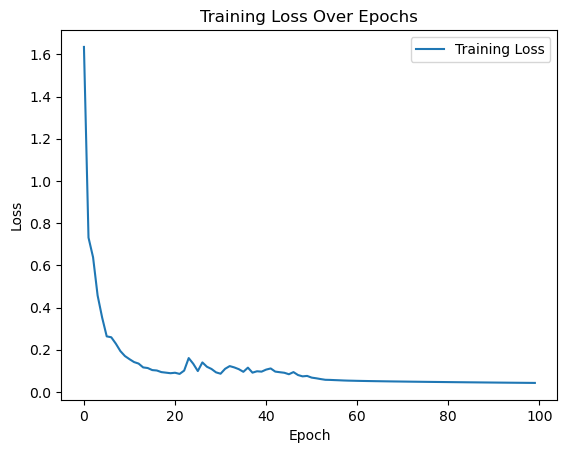

In [198]:
plt.plot(loss_tracker, label='Training Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

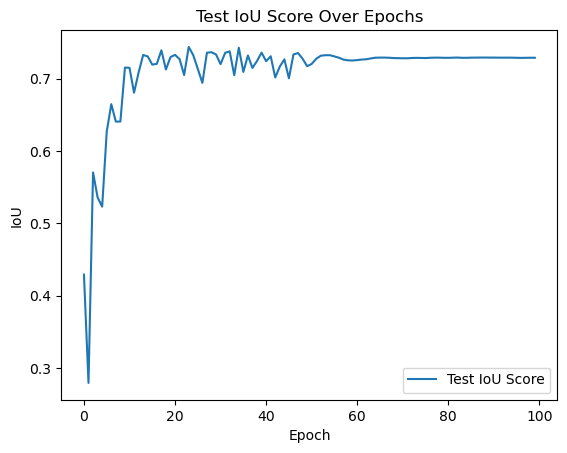

In [199]:
plt.plot(iou_tracker, label='Test IoU Score')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Test IoU Score Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [200]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def get_visualized_label(segmentation_mask, color_encodings):
    cmap = ListedColormap([(0, 0, 0)] + [tuple(color_encodings[i]) for i in range(len(color_encodings))])
    cmap = ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray'])

    colored_mask = cmap(segmentation_mask)[:, :, :3]
    

    return colored_mask

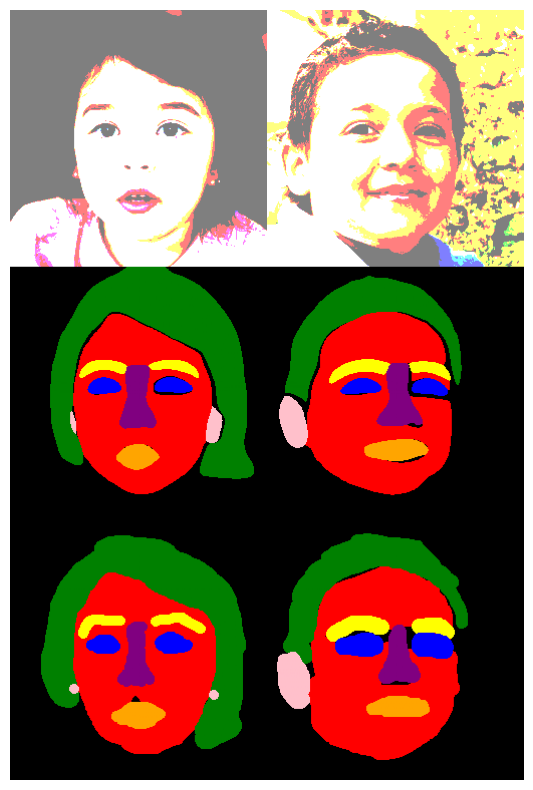

In [201]:
device = 'mps'

test_features = test_features.to(device)

generator.eval().to(device)
net.eval().to(device)
with torch.no_grad():
    torch.cuda.empty_cache()
    out = net(test_features)
    predictions = out.data.max(1)[1].cpu().numpy()

    # visualize
    predictions = np.concatenate([get_visualized_label(pred, color_encodings=test_lbl_encodings) for pred in predictions], axis=1)
    gt = np.concatenate([get_visualized_label(ground_t, color_encodings=test_lbl_encodings) for ground_t in test_labels.flip(0)], axis=1)
    results = np.concatenate([tensor2image(horizontal_concat(test_images.flip(0).float())), predictions, gt], axis=0)
    imshow(results, size=imshow_size*len(test_samples))

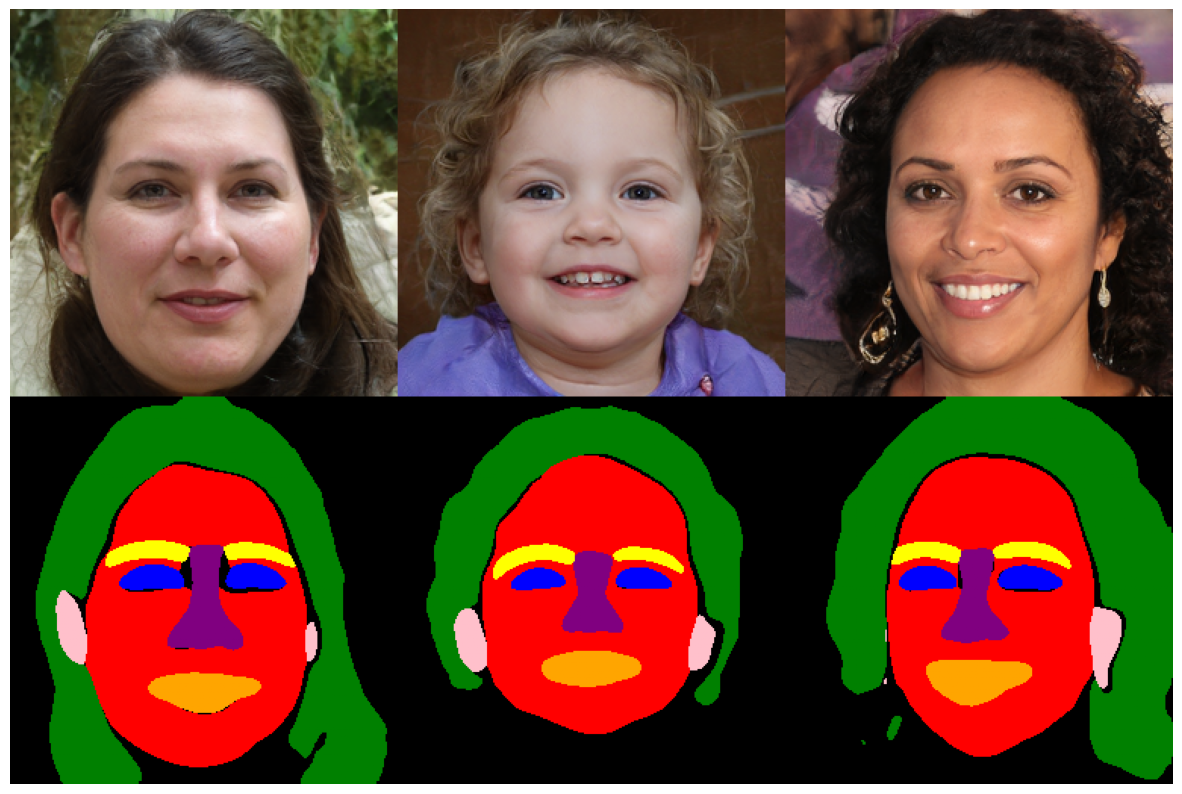

In [208]:
device = 'mps'
n_test = 3

generator.eval().to(device)
net.eval().to(device)
with torch.no_grad():
    latent = generator.get_latent(torch.randn(n_test, latent_dim, device=device))
    imgs_gen, features = generator([latent],
                                   truncation=truncation,
                                   truncation_latent=trunc_mean.to(device),
                                   input_is_latent=True,
                                   randomize_noise=True)

    torch.cuda.empty_cache()
    out = net(concat_features(features))
    predictions = out.data.max(1)[1].cpu().numpy()


    # visualize
    predictions = np.concatenate([get_visualized_label(pred, color_encodings=lbl_encodings) for pred in predictions], axis=1)
    results = np.concatenate([tensor2image(horizontal_concat(imgs_gen.float())), predictions], axis=0)
    imshow(results, size=imshow_size*n_test)

In [206]:
torch.save(net.state_dict(), 'model_weights.pth')

In [37]:
teacher = FewShotCNN(features.shape[1], 8)
student = FewShotCNN(3, 8)
teacher.load_state_dict(torch.load('model_weights.pth'))

teacher.to(device)
student.to(device)

FewShotCNN(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [38]:
import os 
from torch.utils.data import DataLoader, Dataset

class ImageDataset(Dataset):
    def __init__(self, dir):
        
        self.image_dir = os.path.join(dir, 'images')
        self.features_dir = os.path.join(dir, 'features')

    def __len__(self):
        images = os.listdir(self.image_dir)
        images = [file for file in images if file.endswith(('.png'))]
        return len(images[:9])

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.image_dir, f'{idx}.png')))
        image = torch.from_numpy(image).permute(2, 0, 1)

        feature = torch.load(os.path.join(self.features_dir, f'{idx}.pt'))
        return image, feature

In [39]:
dataset = ImageDataset(dir=output_dir)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

In [40]:
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001)
loss1 = nn.KLDivLoss()
loss2 = nn.CrossEntropyLoss()
temperature = 3
alpha = 0.1
epochs = 100
device = 'mps'

In [ ]:
import torch.nn.functional as F

student.train()
teacher.eval()

teacher.to(device)
student.to(device)

for epoch in range(epochs):
    for images, features in dataloader:
        optimizer.zero_grad()

        images = images.to(device)
        features = features.to(device)
    
        student_outputs = student(images.float())
        teacher_outputs = teacher(features.float())

        student_outputs_scaled = F.softmax(student_outputs / temperature, dim=1)
    
        # Calculate the cross-entropy loss for student with teacher's scaled predictions
        distillation_loss = loss1(F.log_softmax(student_outputs / temperature, dim=1),
                                           student_outputs_scaled.detach())
        
        # Calculate the cross-entropy loss for teacher with student's scaled predictions
        inverse_distillation_loss = loss2(student_outputs_scaled.argmax(dim=1),
                                                          student_outputs.argmax(dim=1).float())
    
        # Total loss is a combination of distillation loss and inverse distillation loss
        total_loss = alpha * distillation_loss + (1 - alpha) * inverse_distillation_loss
    
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Mutual Distillation Loss: {total_loss.item():.4f}")
